In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy.stats import linregress, t
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [2]:
Armed_robbery_df = pd.read_excel("Clean_data/Armed_Robberies_GIS.xlsx")[["GEOID","COUNT"]]
Pop_df = pd.read_csv("Clean_data/2013_2018_Underlying Cause of Death, 1999-2020.csv")
Armed_robbery_df["County Code"] = Armed_robbery_df["GEOID"]
Armed_robbery_df["Armed_Rob_Count"] = Armed_robbery_df["COUNT"] 

In [3]:
armed_df = pd.merge(Pop_df, Armed_robbery_df, on='County Code')[["Population","Armed_Rob_Count","County Code"]]
armed_df["Population"] =armed_df["Population"].astype(int)
armed_df["Armed_Rob_Count"] =armed_df["Armed_Rob_Count"].astype(int)
armed_df["MSA_title"] = np.empty(len(armed_df), dtype = str)

In [4]:
MSA_Codes_df = pd.read_excel("Helpers/qcew-county-msa-csa-crosswalk.xlsx", sheet_name = "Feb. 2013 Crosswalk")
for i in range(len(armed_df)):
    couty_code = armed_df["County Code"].iloc[i]
    MSA = MSA_Codes_df[MSA_Codes_df["County Code"]==couty_code]["MSA Code"]
    if len(MSA) !=0:
        armed_df["MSA_title"].iloc[i] = MSA.iloc[0]
armed_df = armed_df[armed_df["MSA_title"]!=""]
MSA_df = armed_df.groupby(['MSA_title']).sum()
MSA_df = MSA_df[MSA_df["Armed_Rob_Count"]!=0]
MSA_df = MSA_df[MSA_df["Population"]!=0]

In [5]:
def scaling(x0,y0,name):
    print(len(x0))
    samis = Get_SAMIs(x0,y0)
    print("Var = ",np.round(np.var(samis),2))
    x = np.log10(x0)
    Y = np.log10(y0)
    X = sm.add_constant(x)
    model = sm.OLS(Y,X)
    fit = model.fit(cov_type='HC1')
    
    
    intercept, slope = fit.params
    print("intercept = ", np.round(intercept,2))
    print("c = ", np.round(10**intercept,2))

    x_0 =  np.sort(x0)[0]
    y_0 = 10**(slope*np.log10(x_0)+intercept)
    
    x_f = np.sort(x0)[-1]
    y_f = 10**(slope*np.log10(x_f)+intercept)
    y_null = 10**(np.log10(x_f)+intercept)
    
    betta = round(slope,2)
    R2 = str(round(fit.rsquared,2))
    beta_lowerbound, beta_upper = fit.conf_int()[1]
    beta_lowerbound = np.round(beta_lowerbound,2)
    beta_upper = np.round(beta_upper,2)

    
    plt.rcParams.update({
    'font.size' : 20,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })
    
    fig,(ax)  = plt.subplots(1, 1, sharey='row',figsize=(6, 6))
    ax.scatter(x0, y0, facecolors='none', edgecolors='k')
    ax.plot([x_0,x_f],[y_0,y_f], lw = 2, color = 'k')
    
    ax.text(0.05,0.95,r'$\beta = {}$'.format("{:.2f}".format(betta))+r'$ \, \in \,[{}$'.format(beta_lowerbound) + r'$,{}]$'.format(beta_upper),
            ha='left', va='top',transform=ax.transAxes)
    ax.text(0.05,0.85,r'$\mathit{R}^2 = $' +r'${}$'.format(R2), ha='left', va='top',transform=ax.transAxes)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Population")
    ax.set_ylabel(name)
 
    ax.set_ylim([0.1,10**4])
    ax.set_yticks([0.1,1,10**1,10**2,10**3,10**4], minor=True)
    
    ax.set_xlim([10**4,10**9])
    ax.set_xticks([10**4,10**5,10**6,10**7,10**8,10**9], minor=True)
    
    plt.show()
    return 

In [6]:
def Get_SAMIs(x0,y0):
    x = np.log10(x0)
    y = np.log10(y0)
    res = linregress(x,y)
    y_hat = res.intercept + res.slope*x
    SAMIs = y-y_hat
    return SAMIs

649
Var =  0.14
intercept =  -5.69
c =  0.0


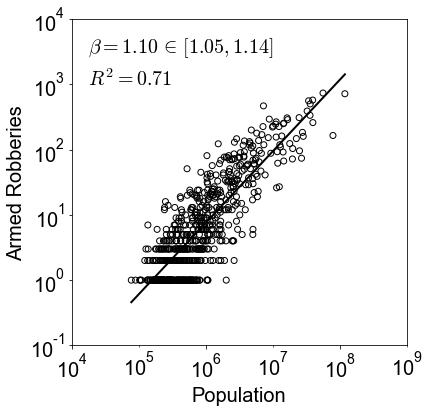

In [7]:
scaling(MSA_df["Population"].values,MSA_df["Armed_Rob_Count"].values, "Armed Robberies")

In [8]:
Armed_Rob_SAMIs = Get_SAMIs(MSA_df["Population"].values,MSA_df["Armed_Rob_Count"].values)

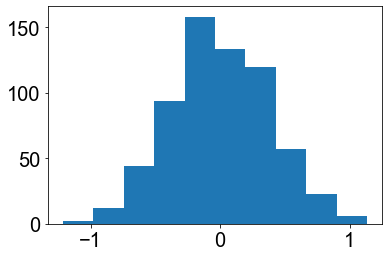

In [9]:
plt.hist(Armed_Rob_SAMIs);